# Get the Data

In [1]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2023-06-18 11:45:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  41.5MB/s    in 4.5s    

2023-06-18 11:45:55 (35.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [2]:
import zipfile
zipfile.ZipFile("./10_food_classes_10_percent.zip").extractall()

# Explore the Data

In [3]:
import os
from glob import glob
train_dir = "/content/10_food_classes_10_percent/train"
test_dir = "/content/10_food_classes_10_percent/test"

def describe_folder(directory):
  list_of_classes = os.listdir(directory)
  print("All the classes in train dir : ", list_of_classes)
  print(" Number of classes in trian dir : ", len(list_of_classes))
  for class_name in list_of_classes:
    print("Number of files in ", class_name , ": ", len(glob(directory + "/" + class_name+"/*")))


In [4]:
describe_folder(train_dir)

All the classes in train dir :  ['chicken_curry', 'ice_cream', 'sushi', 'hamburger', 'fried_rice', 'chicken_wings', 'steak', 'grilled_salmon', 'ramen', 'pizza']
 Number of classes in trian dir :  10
Number of files in  chicken_curry :  75
Number of files in  ice_cream :  75
Number of files in  sushi :  75
Number of files in  hamburger :  75
Number of files in  fried_rice :  75
Number of files in  chicken_wings :  75
Number of files in  steak :  75
Number of files in  grilled_salmon :  75
Number of files in  ramen :  75
Number of files in  pizza :  75


In [5]:
describe_folder(test_dir)

All the classes in train dir :  ['chicken_curry', 'ice_cream', 'sushi', 'hamburger', 'fried_rice', 'chicken_wings', 'steak', 'grilled_salmon', 'ramen', 'pizza']
 Number of classes in trian dir :  10
Number of files in  chicken_curry :  250
Number of files in  ice_cream :  250
Number of files in  sushi :  250
Number of files in  hamburger :  250
Number of files in  fried_rice :  250
Number of files in  chicken_wings :  250
Number of files in  steak :  250
Number of files in  grilled_salmon :  250
Number of files in  ramen :  250
Number of files in  pizza :  250


# Visulize few images

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random

def describe_random_image(directory):
  list_of_classes = os.listdir(directory)

  random_class = random.choice(list_of_classes)

  random_image = random.choice(glob(train_dir + "/" + random_class + "/*"))
  tf_img = tf.io.read_file(random_image)
  tf_img = tf.image.decode_image(tf_img)
  plt.imshow(tf_img)
  plt.axis("off")
  plt.title(random_class + str(tf_img.shape))

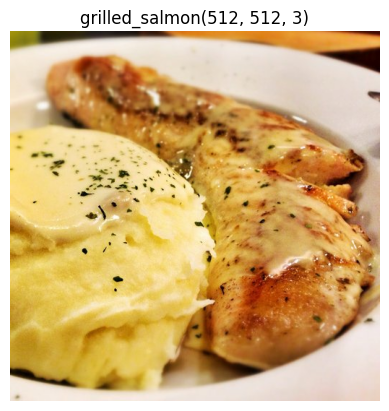

In [7]:
describe_random_image(train_dir)

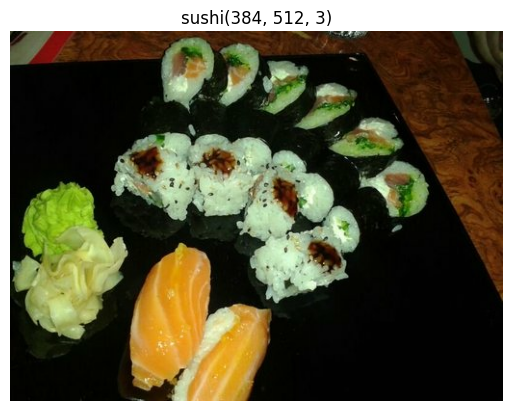

In [8]:
describe_random_image(test_dir)

# Get shape of all images

In [9]:
import numpy as np
def get_average_img_dims(directory):
  x_dim_set = set()
  y_dim_set = set()
  for cls in os.listdir(train_dir):
    for img in glob(train_dir + "/" + cls + "/*"):
      tf_img = tf.io.read_file(img)
      tf_img = tf.image.decode_image(tf_img)
      x_dim_set.add(tf_img.shape[0])
      y_dim_set.add(tf_img.shape[1])
  return np.mean(list(x_dim_set)), np.mean(list(y_dim_set))

In [10]:
x_dim, y_dim = get_average_img_dims(train_dir)
print("Average image size of train data : ", x_dim, y_dim)

Average image size of train data :  362.38235294117646 389.2


In [11]:
x_dim, y_dim = get_average_img_dims(test_dir)
print("Average image size of test data : ", x_dim, y_dim)

Average image size of test data :  362.38235294117646 389.2


It is better to reshape all the images to 400 x 400 before passing them into model.

# Preprocessing and Loading Data

In [12]:
resize_and_normalize = tf.keras.Sequential(
    [
    tf.keras.layers.Resizing(height=400, width=400),
    tf.keras.layers.Rescaling(scale=1/255.)
    ])

augmentation_dataset = tf.keras.Sequential([

                               tf.keras.layers.RandomFlip(mode="horizontal_and_vertical", seed=42),
                               tf.keras.layers.RandomRotation(factor=0.2, seed=42),
                               tf.keras.layers.RandomContrast(factor=0.2, seed=42),
])

In [13]:
train_data, valid_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                                      batch_size=32,
                                                                      image_size=(400,400),
                                                                      shuffle=True,
                                                                      seed=42,
                                                                      validation_split=0.2,
                                                                      subset="both",
                                                                     class_names=os.listdir(train_dir)
                                                                     )

test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        batch_size=32,
                                                        image_size=(400,400),
                                                        shuffle=True,
                                                        seed=42,
                                                        class_names=os.listdir(test_dir)
                                                        )

Found 750 files belonging to 10 classes.
Using 600 files for training.
Using 150 files for validation.
Found 2500 files belonging to 10 classes.


In [14]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_normalize(x), y),
              num_parallel_calls=AUTOTUNE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (augmentation_dataset(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_data_aug = prepare(train_data, augment=True)
train_data = prepare(train_data, augment=False)

valid_data = prepare(valid_data, augment=False)
test_data = prepare(test_data, augment=False)

In [16]:
len(train_data), len(valid_data), len(test_data), len(train_data_aug)

(19, 5, 79, 19)

In [17]:
trian_data_concat = train_data.concatenate(train_data_aug)
trian_data_concat = trian_data_concat.shuffle(buffer_size=32)

In [18]:
len(trian_data_concat)

38

# Visulize data from Datasets

tf.Tensor([2 6 0 2 0 5 5 7 2 9 3 2 4 3 0 5 9 4 5 2 4 2 1 8 7 9 2 1 1 0 0 7], shape=(32,), dtype=int32)
tf.Tensor([8 7 5 5 0 9 4 2 3 5 9 3 3 4 0 9 0 6 1 3 0 3 7 8 1 1 3 1 9 7 1 5], shape=(32,), dtype=int32)


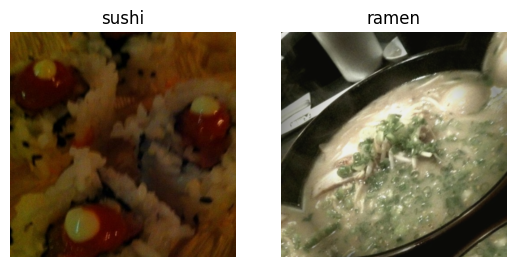

In [19]:
class_names = os.listdir(train_dir)
for x,y in train_data:
  print(y)
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(x[0])
  plt.title(class_names[y[0]])
  plt.axis("off")
  break

for x,y in train_data_aug:
  print(y)
  plt.subplot(1,2,2)
  plt.imshow(x[0])
  plt.title(class_names[y[0]])
  plt.axis("off")
  break

tf.Tensor([2 2 6 6 8 8 5 7 4 9 0 8 4 6 6 2 5 8 7 8 9 8 6 4 1 1 6 4 0 6 6 8], shape=(32,), dtype=int32)
tf.Tensor([1 7 6 7 6 1 8 9 7 6 3 4 3 1 1 3 0 5 0 1 1 4 9 0 8 2 2 0 3 2 9 3], shape=(32,), dtype=int32)


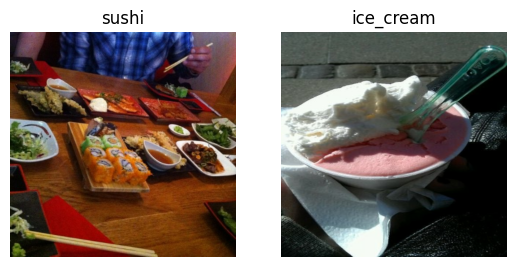

In [20]:
class_names = os.listdir(train_dir)
for x,y in valid_data:
  print(y)
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(x[0])
  plt.title(class_names[y[0]])
  plt.axis("off")
  break
class_names = os.listdir(test_dir)
for x,y in test_data:
  print(y)
  plt.subplot(1,2,2)
  plt.imshow(x[0])
  plt.title(class_names[y[0]])
  plt.axis("off")
  break

# Build, Compile, Fit the Model

# Experiment - 1

In [21]:
model_1 = tf.keras.Sequential(
                                [
                                  tf.keras.layers.Input(shape=(400,400,3)),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(units=10,activation="softmax")

                              ]
                            )

print(model_1.summary())

model_1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

hist_1 = model_1.fit(train_data,epochs=5,
            steps_per_epoch=len(train_data),
            validation_data=valid_data,
            validation_steps=len(valid_data))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 10)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 10)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 10)        910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 10)      

In [22]:
model_1.compile(test_data)

ValueError: ignored

In [ ]:
import pandas as pd
fig, axes = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(hist_1.history)[["loss","val_loss"]].plot(title="Loss Plots",ax=axes[0],figsize=(10,5))
pd.DataFrame(hist_1.history)[["accuracy","val_accuracy"]].plot(title="Accuracy Plots",ax=axes[1],figsize=(10,5))

## Experiment - 2

In [ ]:
tf.random.set_seed(42)
model_2 = tf.keras.Sequential(
                                [
                                  tf.keras.layers.Input(shape=(400,400,3)),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(units=10,activation="softmax")

                              ]
                            )

print(model_2.summary())

model_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

hist_2 = model_2.fit(train_data_aug,epochs=5,
            steps_per_epoch=len(train_data_aug),
            validation_data=valid_data,
            validation_steps=len(valid_data))

In [ ]:
import pandas as pd
fig, axes = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(hist_2.history)[["loss","val_loss"]].plot(title="Loss Plots",ax=axes[0],figsize=(10,5))
pd.DataFrame(hist_2.history)[["accuracy","val_accuracy"]].plot(title="Accuracy Plots",ax=axes[1],figsize=(10,5))

## Experiment -3

In [ ]:
tf.random.set_seed(42)
model_3 = tf.keras.Sequential(
                                [
                                  tf.keras.layers.Input(shape=(400,400,3)),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Conv2D(filters=10, kernel_size=3, activation="relu"),
                                  tf.keras.layers.MaxPool2D(),
                                  tf.keras.layers.Flatten(),
                                  tf.keras.layers.Dense(units=10,activation="softmax")

                              ]
                            )

print(model_3.summary())

model_3.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

hist_3 = model_3.fit(trian_data_concat,epochs=5,
            steps_per_epoch=len(trian_data_concat),
            validation_data=valid_data,
            validation_steps=len(valid_data))

In [ ]:
import pandas as pd
fig, axes = plt.subplots(nrows=1, ncols=2)
pd.DataFrame(hist_3.history)[["loss","val_loss"]].plot(title="Loss Plots",ax=axes[0],figsize=(10,5))
pd.DataFrame(hist_3.history)[["accuracy","val_accuracy"]].plot(title="Accuracy Plots",ax=axes[1],figsize=(10,5))